# Import needed modules

In [3]:
import os
import time
import shutil
import pathlib
import itertools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import int32
from tensorflow.random import uniform
from tensorflow.image import per_image_standardization, random_flip_left_right, rot90
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, smart_resize
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers, models, layers
from tensorflow.keras.applications import efficientnet # Transfert Learning Model's Family 
from keras.callbacks import ReduceLROnPlateau
from tabulate import tabulate
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **Data Preprocessing**

### **Read data and store it in dataframe**

In [4]:
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
# Define the directory paths for the normal and abnormal data
normal_dirs = ['train/NORMAL', 'test/NORMAL', 'val/NORMAL']
abnormal_dirs = ['train/PNEUMONIA', 'test/PNEUMONIA', 'val/PNEUMONIA']
# Create a new directory to store the transformed data
os.makedirs(os.path.join('/kaggle/working/new_data'), exist_ok=True)
# Loop through the normal and abnormal directories, and copy the images to the new directory
for directory in normal_dirs + abnormal_dirs:
    src_dir = os.path.join(data_dir, directory)
    filenames = os.listdir(src_dir)
    for filename in filenames:
        src_path = os.path.join(src_dir, filename)
        dst_path = os.path.join('/kaggle/working/new_data', directory.split('/')[1], filename)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

In [5]:
# Generate data paths with labels
data_dir = '/kaggle/working/new_data'
filepaths = []
labels = []
folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [6]:
# train dataframe
train_ds, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)
# valid and test dataframe
val_ds, test_ds = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

### **Create image data generator**

In [7]:
BATCH_SIZE = 16
IMAGE_SIZE= 224
IMG_SIZE = (IMAGE_SIZE, IMAGE_SIZE)
CHANNELS = 3
EPOCHS=20
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
#We can use our proposed BATCH_SIZE form above but it's better if we calculate the test_batch_size for optimal value
test_len = len(test_ds)
test_batch_size = max(sorted([test_len // n for n in range(1, test_len + 1) if test_len%n == 0 and test_len/n <= 80]))
test_steps = test_len // test_batch_size

In [8]:
def data_augmentation(img):
    resized = smart_resize(img, IMG_SIZE)
    scaled = per_image_standardization(resized)
    flipped = random_flip_left_right(scaled)
    rotated = rot90(flipped, k=uniform(shape=[], minval=0, maxval=4, dtype=int32))
    return img #the new generated image after after 4layers of mods
#this function replace the data_augmentation sequencial layer
data_gen= ImageDataGenerator(preprocessing_function= data_augmentation)

train_gen = data_gen.flow_from_dataframe(train_ds, x_col= 'filepaths', y_col= 'labels', target_size= IMG_SIZE, class_mode= 'binary',
                                    color_mode= 'rgb', shuffle= True, batch_size= BATCH_SIZE)

valid_gen = data_gen.flow_from_dataframe(val_ds, x_col= 'filepaths', y_col= 'labels', target_size= IMG_SIZE, class_mode= 'binary',
                                    color_mode= 'rgb', shuffle= True, batch_size= BATCH_SIZE)

test_gen = data_gen.flow_from_dataframe(test_ds, x_col= 'filepaths', y_col= 'labels', target_size= IMG_SIZE, class_mode= 'binary',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 4684 validated image filenames belonging to 2 classes.
Found 703 validated image filenames belonging to 2 classes.
Found 469 validated image filenames belonging to 2 classes.


In [9]:
class_count = len(list(train_gen.class_indices.keys()))/2

# **Model Structure**

**Our own dev CNN model**

In [10]:
model1 = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation='relu' ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation='relu' ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation='relu' ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation='relu' ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3) ,activation='relu' ),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(class_count,activation='sigmoid'),
])

model1.build(input_shape=input_shape)  # Build the model

model1.compile(Adamax(lr=0.001), loss= 'binary_crossentropy', metrics= ['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

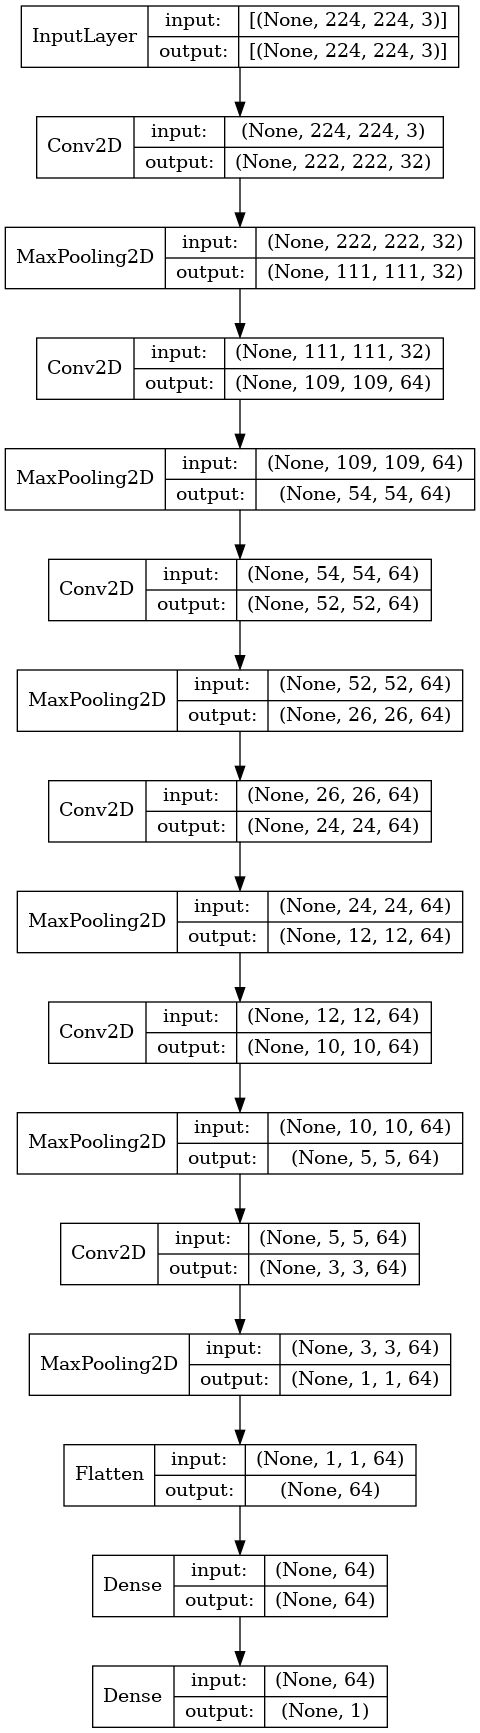

In [11]:
# plot the model architecture
plot_model(model1, to_file='/kaggle/working/new_data/model1.png', show_shapes=True, show_layer_names=False)

# display the image
Image(filename='/kaggle/working/new_data/model1.png')

#### **Transfert Learning Model Creation**

In [12]:
# create pre-trained model such as :  efficientnet, VGG, Resnet...
# we will use efficientnetb3 from EfficientNet family.
base_model = efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= input_shape, pooling= 'max')
# base_model.trainable = False

model2 = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'sigmoid')
])

model2.compile(Adamax(learning_rate= 0.001), loss= 'binary_crossentropy', metrics= ['accuracy'])

model2.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 4,382,884
Trainable params: 4,338,301
Non

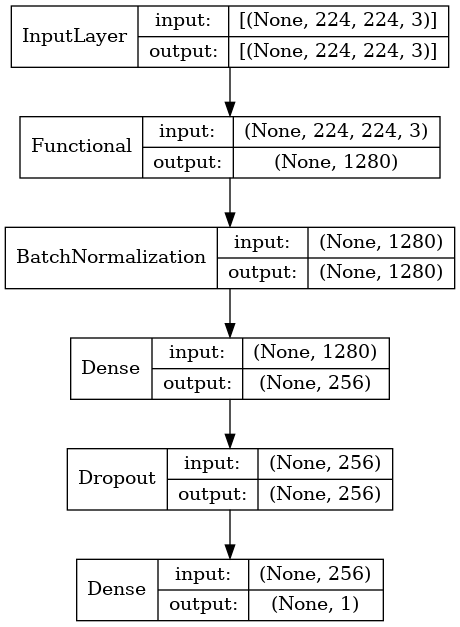

In [13]:
# plot the model architecture
plot_model(model2, to_file='/kaggle/working/new_data/model2.png', show_shapes=True, show_layer_names=False)

# display the image
Image(filename='/kaggle/working/new_data/model2.png')

#### **Train model**

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [15]:
history1 = model1.fit(x= train_gen, epochs= EPOCHS, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False, callbacks = [learning_rate_reduction])

Epoch 1/20
293/293 [==============================] - 95s 304ms/step - loss: 0.6034 - accuracy: 0.7927 - val_loss: 0.3066 - val_accuracy: 0.9047 - lr: 0.0010
Epoch 2/20
293/293 [==============================] - 87s 297ms/step - loss: 0.2476 - accuracy: 0.8962 - val_loss: 0.1969 - val_accuracy: 0.9289 - lr: 0.0010
Epoch 3/20
293/293 [==============================] - 88s 299ms/step - loss: 0.1989 - accuracy: 0.9246 - val_loss: 0.1712 - val_accuracy: 0.9246 - lr: 0.0010
Epoch 4/20
293/293 [==============================] - 86s 295ms/step - loss: 0.1765 - accuracy: 0.9355 - val_loss: 0.1726 - val_accuracy: 0.9303 - lr: 0.0010
Epoch 5/20
293/293 [==============================] - 86s 294ms/step - loss: 0.1512 - accuracy: 0.9413 - val_loss: 0.1723 - val_accuracy: 0.9289 - lr: 0.0010
Epoch 6/20
293/293 [==============================] - 86s 294ms/step - loss: 0.1446 - accuracy: 0.9466 - val_loss: 0.1516 - val_accuracy: 0.9388 - lr: 0.0010
Epoch 7/20
293/293 [==============================] 

In [16]:
history2 = model2.fit(x= train_gen, epochs= EPOCHS, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False, callbacks = [learning_rate_reduction])

Epoch 1/20
293/293 [==============================] - 126s 399ms/step - loss: 4.4846 - accuracy: 0.9236 - val_loss: 2.5542 - val_accuracy: 0.9559 - lr: 0.0010
Epoch 2/20
293/293 [==============================] - 115s 391ms/step - loss: 1.7127 - accuracy: 0.9609 - val_loss: 1.0909 - val_accuracy: 0.9687 - lr: 0.0010
Epoch 3/20
293/293 [==============================] - 114s 388ms/step - loss: 0.7821 - accuracy: 0.9688 - val_loss: 0.5261 - val_accuracy: 0.9815 - lr: 0.0010
Epoch 4/20
293/293 [==============================] - 113s 387ms/step - loss: 0.4245 - accuracy: 0.9746 - val_loss: 0.3439 - val_accuracy: 0.9730 - lr: 0.0010
Epoch 5/20
293/293 [==============================] - ETA: 0s - loss: 0.2760 - accuracy: 0.9829
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
293/293 [==============================] - 115s 392ms/step - loss: 0.2760 - accuracy: 0.9829 - val_loss: 0.2529 - val_accuracy: 0.9730 - lr: 0.0010
Epoch 6/20
293/293 [========================

#### **Display model performance**

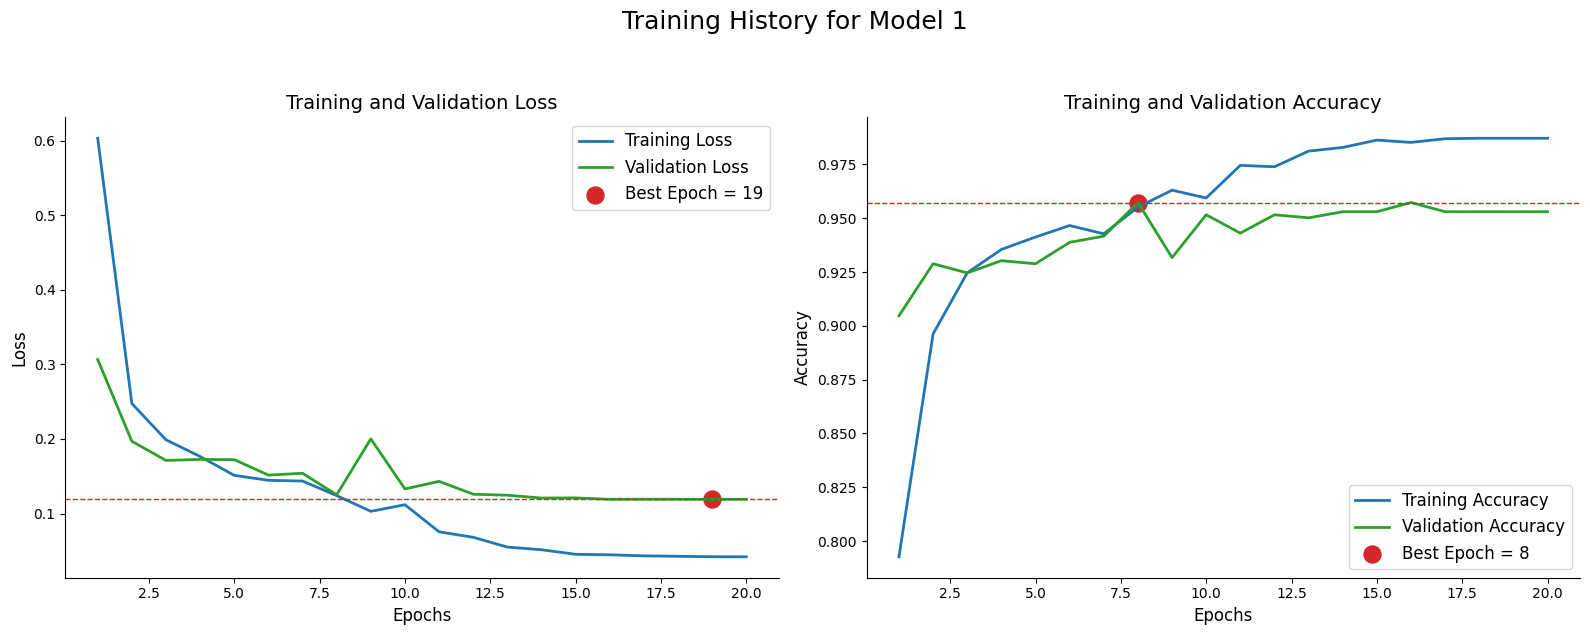

In [17]:
# Define needed variables
tr_acc = history1.history['accuracy']
tr_loss = history1.history['loss']
val_acc = history1.history['val_accuracy']
val_loss = history1.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,6))

# Customize the first subplot
ax1.plot(Epochs, tr_loss, color='tab:blue', label='Training Loss', linewidth=2)
ax1.plot(Epochs, val_loss, color='tab:green', label='Validation Loss', linewidth=2)
ax1.scatter(index_loss + 1, val_lowest, s= 150, c= 'tab:red', label=loss_label)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14)
ax1.legend(fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Add a horizontal line for minimum validation loss
ax1.axhline(y=val_lowest, color='tab:red', linestyle='--', linewidth=1)
ax1.annotate(f'{val_lowest:.3f}', xy=(0, val_lowest), xytext=(10, 0), textcoords='offset points', va='center', ha='left', color='tab:red')

# Customize the second subplot
ax2.plot(Epochs, tr_acc, color='tab:blue', label='Training Accuracy', linewidth=2)
ax2.plot(Epochs, val_acc, color='tab:green', label='Validation Accuracy', linewidth=2)
ax2.scatter(index_acc + 1 , acc_highest, s= 150, c= 'tab:red', label=acc_label)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14)
ax2.legend(fontsize=12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Add a horizontal line for maximum validation accuracy
ax2.axhline(y=acc_highest, color='tab:red', linestyle='--', linewidth=1)
ax2.annotate(f'{acc_highest:.3f}', xy=(0, acc_highest), xytext=(10, 0), textcoords='offset points', va='center', ha='left', color='tab:red')

# Add a title and adjust spacing
plt.suptitle('Training History for Model 1', fontsize=18, y=1.05)
plt.tight_layout()

# Display the figure
plt.show()


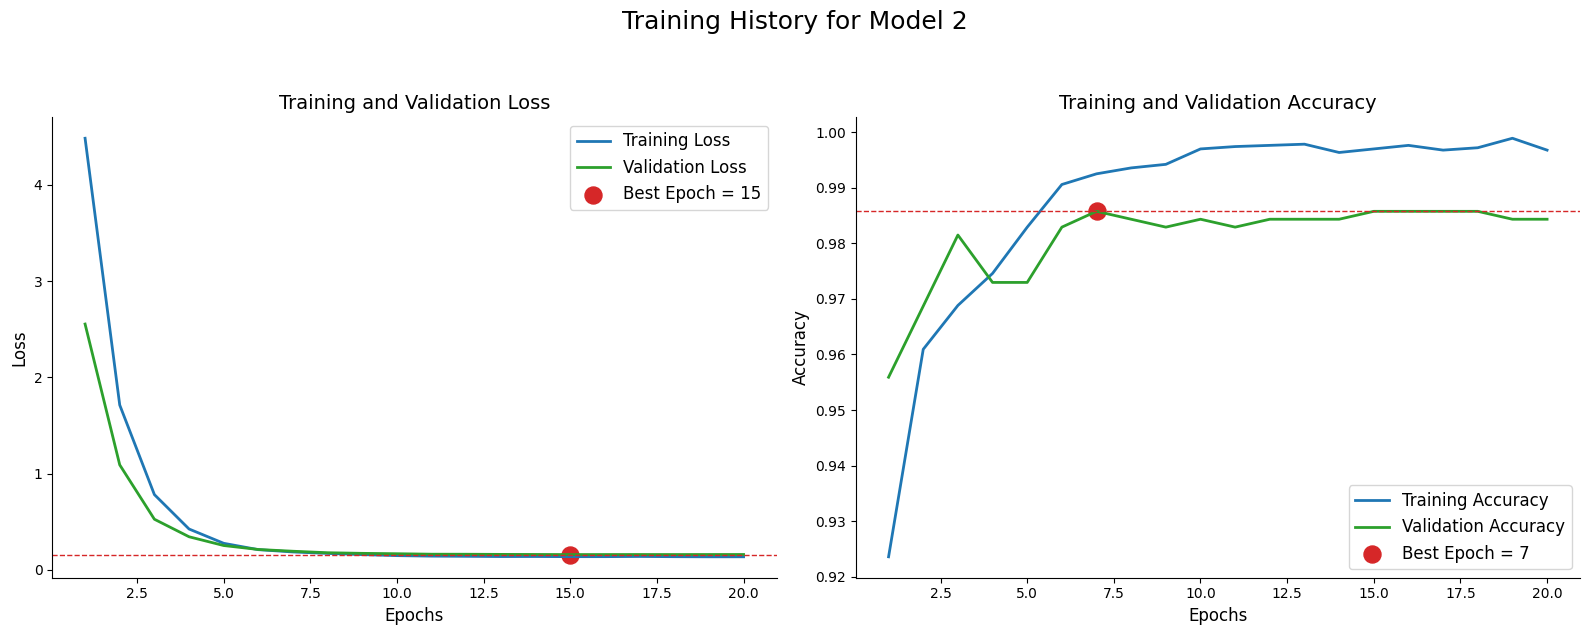

In [18]:
# Define needed variables
tr_acc = history2.history['accuracy']
tr_loss = history2.history['loss']
val_acc = history2.history['val_accuracy']
val_loss = history2.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,6))

# Customize the first subplot
ax1.plot(Epochs, tr_loss, color='tab:blue', label='Training Loss', linewidth=2)
ax1.plot(Epochs, val_loss, color='tab:green', label='Validation Loss', linewidth=2)
ax1.scatter(index_loss + 1, val_lowest, s= 150, c= 'tab:red', label=loss_label)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14)
ax1.legend(fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Add a horizontal line for minimum validation loss
ax1.axhline(y=val_lowest, color='tab:red', linestyle='--', linewidth=1)
ax1.annotate(f'{val_lowest:.3f}', xy=(0, val_lowest), xytext=(10, 0), textcoords='offset points', va='center', ha='left', color='tab:red')

# Customize the second subplot
ax2.plot(Epochs, tr_acc, color='tab:blue', label='Training Accuracy', linewidth=2)
ax2.plot(Epochs, val_acc, color='tab:green', label='Validation Accuracy', linewidth=2)
ax2.scatter(index_acc + 1 , acc_highest, s= 150, c= 'tab:red', label=acc_label)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14)
ax2.legend(fontsize=12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Add a horizontal line for maximum validation accuracy
ax2.axhline(y=acc_highest, color='tab:red', linestyle='--', linewidth=1)
ax2.annotate(f'{acc_highest:.3f}', xy=(0, acc_highest), xytext=(10, 0), textcoords='offset points', va='center', ha='left', color='tab:red')

# Add a title and adjust spacing
plt.suptitle('Training History for Model 2', fontsize=18, y=1.05)
plt.tight_layout()

# Display the figure
plt.show()


# **Evaluate model**

In [19]:
train_score1 = model1.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score1 = model1.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score1 = model1.evaluate(test_gen, steps= test_steps, verbose= 1)

7/7 [==============================] - 8s 1s/step - loss: 0.1456 - accuracy: 0.9510


In [20]:
# Create table with evaluation scores
table = [['Train', train_score1[0], train_score1[1]],
         ['Validation', valid_score1[0], valid_score1[1]],
         ['Test', test_score1[0], test_score1[1]]]

# Print table
print(tabulate(table, headers=['Set', 'Loss', 'Accuracy'], tablefmt='orgtbl'))


| Set        |      Loss |   Accuracy |
|------------+-----------+------------|
| Train      | 0.0905612 |   0.964286 |
| Validation | 0.121502  |   0.964286 |
| Test       | 0.145616  |   0.95096  |


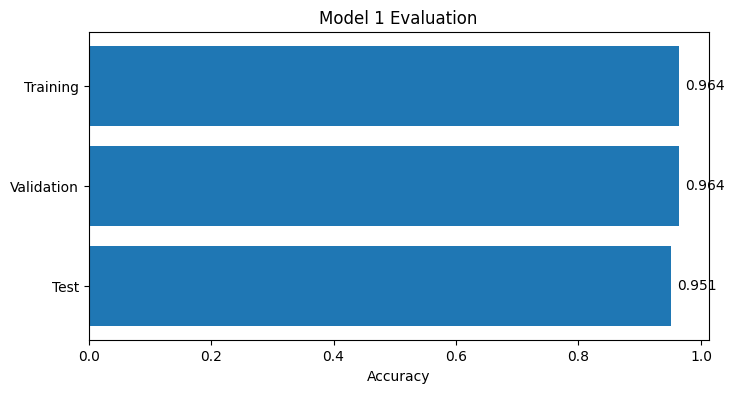

In [21]:
# Define data and labels
data = [train_score1[1], valid_score1[1], test_score1[1]]
labels = ['Training', 'Validation', 'Test']

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(labels, data, color='tab:blue')

# Add labels and formatting
ax.set_xlabel('Accuracy')
ax.set_title('Model 1 Evaluation')
ax.invert_yaxis()

# Add value labels to bars
for i, v in enumerate(data):
    ax.text(v + 0.01, i, f'{v:.3f}', ha='left', va='center')

plt.show()


In [22]:
train_score2 = model2.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score2 = model2.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score2 = model2.evaluate(test_gen, steps= test_steps, verbose= 1)

7/7 [==============================] - 9s 1s/step - loss: 0.1519 - accuracy: 0.9872


In [23]:
# Create table with evaluation scores
table = [['Train', train_score2[0], train_score2[1]],
         ['Validation', valid_score2[0], valid_score2[1]],
         ['Test', test_score2[0], test_score2[1]]]

# Print table
print(tabulate(table, headers=['Set', 'Loss', 'Accuracy'], tablefmt='orgtbl'))


| Set        |     Loss |   Accuracy |
|------------+----------+------------|
| Train      | 0.119233 |   1        |
| Validation | 0.138064 |   0.991071 |
| Test       | 0.151919 |   0.987207 |


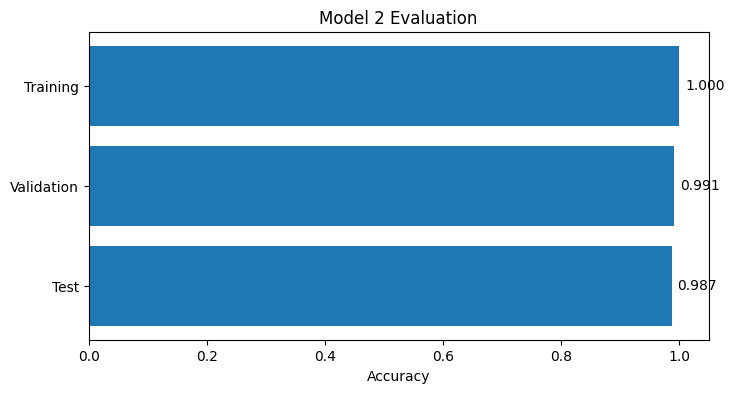

In [24]:
# Define data and labels
data = [train_score2[1], valid_score2[1], test_score2[1]]
labels = ['Training', 'Validation', 'Test']

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(labels, data, color='tab:blue')

# Add labels and formatting
ax.set_xlabel('Accuracy')
ax.set_title('Model 2 Evaluation')
ax.invert_yaxis()

# Add value labels to bars
for i, v in enumerate(data):
    ax.text(v + 0.01, i, f'{v:.3f}', ha='left', va='center')

plt.show()


# **Get Predictions**

In [25]:
preds1 = model1.predict_generator(test_gen)
y_pred1 = (preds1 > 0.5).astype(int)  # use threshold of 0.5 to determine class

In [26]:
preds2 = model2.predict_generator(test_gen)
y_pred2 = (preds2 > 0.5).astype(int)

#### **Confusion Matrics and Classification Report**

In [27]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
sns.set_style('darkgrid')

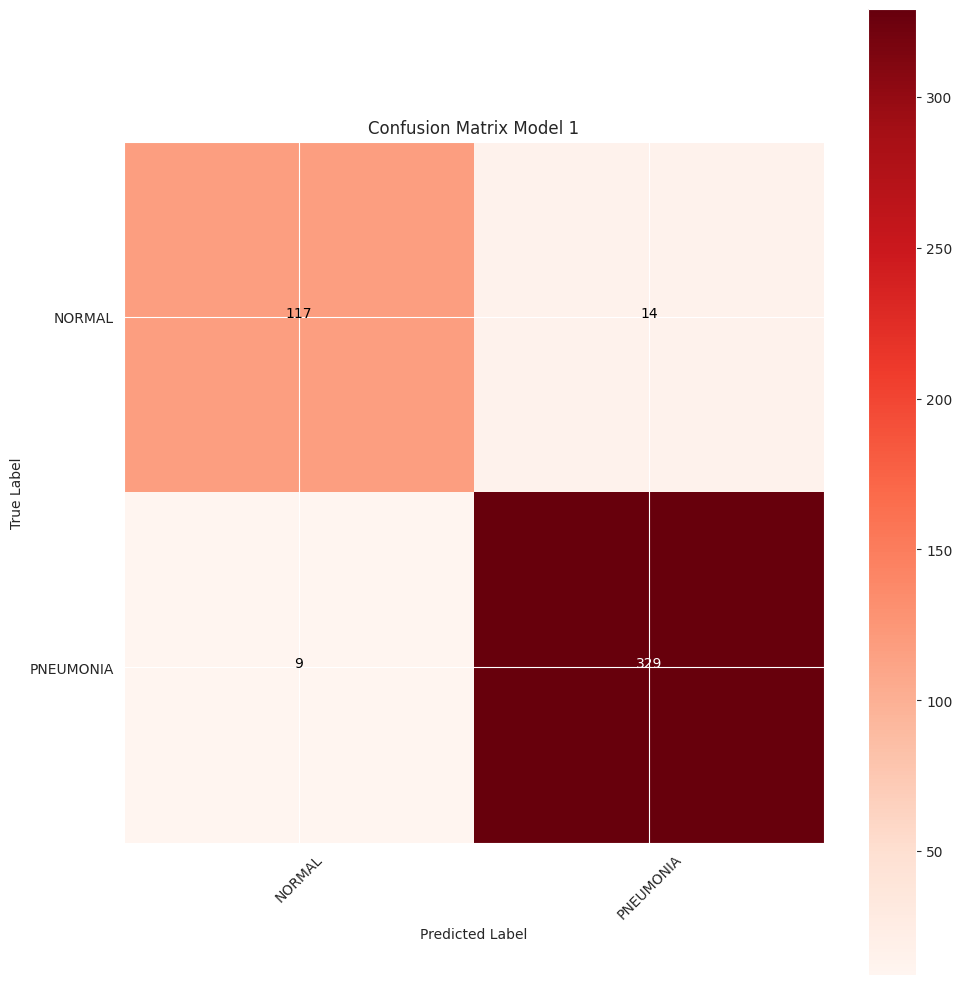

In [28]:
# Confusion matrix
cm1 = confusion_matrix(test_gen.classes, y_pred1)
plt.figure(figsize= (10, 10))
plt.imshow(cm1, interpolation= 'nearest', cmap= plt.cm.Reds)
plt.title('Confusion Matrix Model 1')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm1.max() / 2.
for i, j in itertools.product(range(cm1.shape[0]), range(cm1.shape[1])):
    plt.text(j, i, cm1[i, j], horizontalalignment= 'center', color= 'white' if cm1[i, j] > thresh else 'black')
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


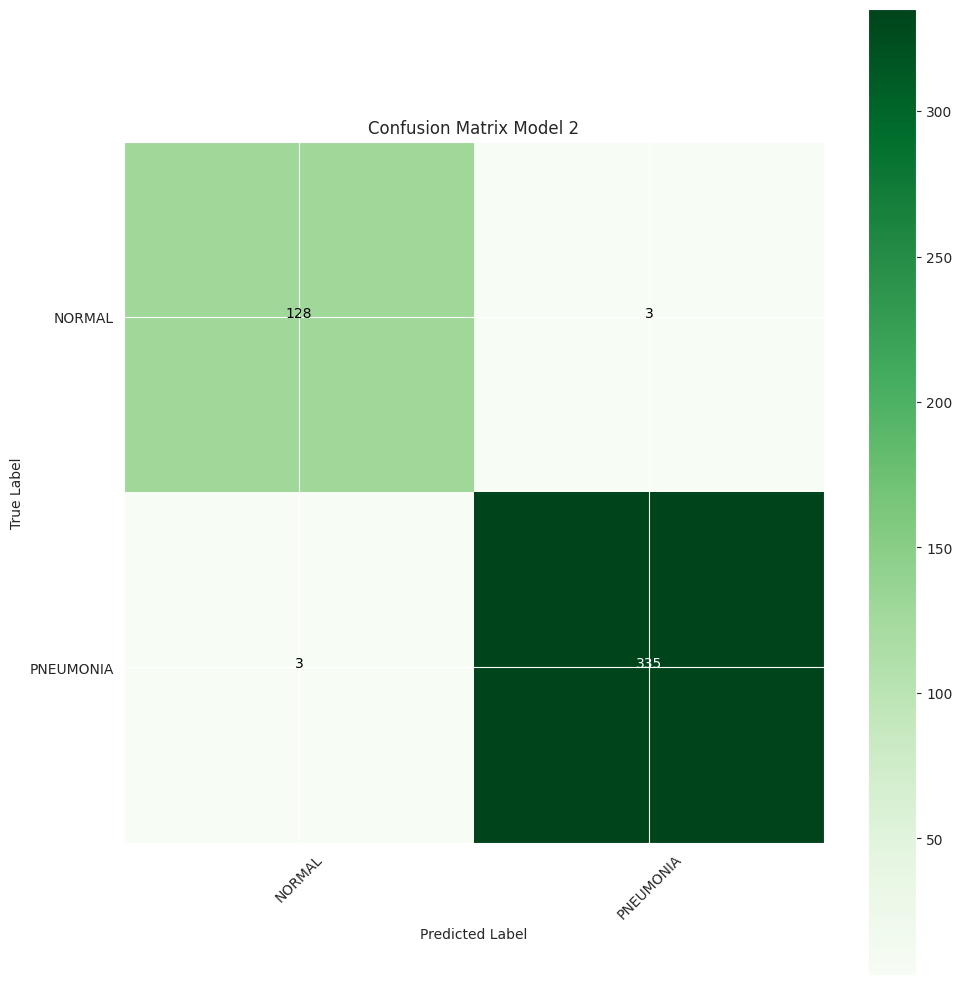

In [29]:
# Confusion matrix
cm2 = confusion_matrix(test_gen.classes, y_pred2)
plt.figure(figsize= (10, 10))
plt.imshow(cm2, interpolation= 'nearest', cmap= plt.cm.Greens)
plt.title('Confusion Matrix Model 2')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm2.max() / 2.
for i, j in itertools.product(range(cm2.shape[0]), range(cm2.shape[1])):
    plt.text(j, i, cm2[i, j], horizontalalignment= 'center', color= 'white' if cm2[i, j] > thresh else 'black')
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [30]:
# Classification report
print(classification_report(test_gen.classes, y_pred1, target_names= classes))

              precision    recall  f1-score   support

      NORMAL       0.93      0.89      0.91       131
   PNEUMONIA       0.96      0.97      0.97       338

    accuracy                           0.95       469
   macro avg       0.94      0.93      0.94       469
weighted avg       0.95      0.95      0.95       469



In [31]:
# Classification report
print(classification_report(test_gen.classes, y_pred2, target_names= classes))

              precision    recall  f1-score   support

      NORMAL       0.98      0.98      0.98       131
   PNEUMONIA       0.99      0.99      0.99       338

    accuracy                           0.99       469
   macro avg       0.98      0.98      0.98       469
weighted avg       0.99      0.99      0.99       469



#### **Save model**

In [32]:
model2.save(f"/kaggle/working/new_data/usingefficientnet.h5")

In [33]:
model1.save(f"/kaggle/working/new_data/ourowndevcnn.h5")